In [1]:
import numpy as np
import torch
from torch import nn, optim
from torch.autograd import Variable

In [2]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.linear = nn.Linear(10, 1, bias = True)
        self.centers = torch.nn.Parameter(torch.randn((10, 2)), requires_grad=True) #随机初始化中心并将其加入网络中训练
        self.beta = torch.nn.Parameter(torch.randn(10), requires_grad=True)  #随机初始化宽度参数并将其加入网络中训练
        #self.centers = torch.randn((10, 2)) #随机初始化中心
        #self.beta = torch.randn(10)  #随机初始化宽度参数


    def kernel_fun(self, x):
        self.X_train = x
        x1 = self.X_train.repeat(1, 10)
        x2 = torch.reshape(x1,[-1, 10, 2])
        dist = (x2-self.centers)**2
        dist = dist.sum(2, keepdim = False)
        return torch.exp(-dist/(2*self.beta**2))


    def forward(self, x):
        x = self.kernel_fun(x)
        x = self.linear(x)
        return x

In [3]:
torch.manual_seed(42)
 
class RBFNN(DNN):
    def __init__(self, X_train, Y_eaxct):
        super(RBFNN, self).__init__()
        self.X_train = X_train
        self.Y_eaxct = Y_eaxct
        self.feature = 2 #输入数据的特征数
        self.hidden_size = 10 # 隐层节点的个数
        self.n_out = 1 #输出维数
        self.epoch = 0
        self.criterion = nn.MSELoss()
        self.dnn = DNN()
        self.params = self.dnn.parameters()
        self.criterion = torch.nn.MSELoss()
        self.optimizer = torch.optim.SGD(self.params,lr=0.01,momentum=0.9)
       


    def loss_fun(self):
        self.optimizer.zero_grad()
        out = self.dnn(self.X_train)
        loss = self.criterion(out,self.Y_eaxct)
        #反向传播
        loss.backward()

        self.epoch += 1
        #每一千次迭代输出损失函数的值
        if self.epoch % 1000 ==0:
            print('Epoch:{}, loss:{:5e}'.\
                format(self.epoch, loss.item()))
        
        return loss

    def train(self):
        for i in range(10000):
            self.dnn.train()
            self.optimizer.step(self.loss_fun)


    def predict(self, X):
        self.dnn.eval()

        z = self.dnn(X)
        #detach(),阻断反向传播；cpu（）将数据放到cpu上；numpy（）将Tensor转化为numpy
        z = z.detach().cpu().numpy()

        return z

Epoch:1000, loss:9.922150e-01
Epoch:2000, loss:7.668997e-01
Epoch:3000, loss:7.027985e-01
Epoch:4000, loss:6.726687e-01
Epoch:5000, loss:6.553138e-01
Epoch:6000, loss:6.440408e-01
Epoch:7000, loss:6.360977e-01
Epoch:8000, loss:6.301585e-01
Epoch:9000, loss:6.255043e-01
Epoch:10000, loss:6.217057e-01


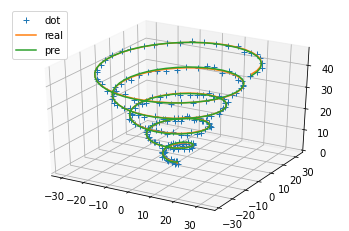

{'centers': Parameter containing:
tensor([[-0.9342, -0.2483],
        [-1.2082, -0.4777],
        [-0.2168, -1.3847],
        [-0.8712, -0.2234],
        [ 1.7174,  0.3189],
        [-0.4245,  0.3057],
        [ 0.3309, -1.5576],
        [ 0.9956, -0.8798],
        [-0.6011, -1.2742],
        [ 2.1228, -1.2347]], requires_grad=True), 'beta': Parameter containing:
tensor([-0.2747, -1.2552, -0.7813,  0.2293, -1.2754, -1.9245,  0.4336,  0.6641,
        -0.4337, -0.4201], requires_grad=True), 'linear.weight': Parameter containing:
tensor([[ 0.2418,  0.2625, -0.0741,  0.2905, -0.0693,  0.0638, -0.1540,  0.1857,
          0.2788, -0.2320]], requires_grad=True), 'linear.bias': Parameter containing:
tensor([0.2749], requires_grad=True), 'dnn.centers': Parameter containing:
tensor([[-0.5908, -0.5997],
        [ 0.1996, -0.7229],
        [ 0.7846,  0.0286],
        [ 0.6408,  0.5832],
        [ 0.9884, -0.5268],
        [-0.7111,  0.5839],
        [ 0.3126,  4.3793],
        [ 0.9532, -0.5685],


In [4]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
#待逼近的函数
def fun(t):
    x1=(t+0.5*np.pi)*np.sin(t+0.5*np.pi)
    x2=(t+0.5*np.pi)*np.cos(t+0.5*np.pi)
    y=1.5*t
    x=np.append(x1,x2,1)
    return x,y
 
#生成样本
def generate_samples():
    n=200 #样本点个数
    wideX=0.6 #水平方向噪声的宽度
    wideY=1 #纵轴噪声宽度
    t=np.linspace(0,10*np.pi,n).reshape(-1,1) #横轴理想值
    u,v=fun(t) #纵轴理想值
    noisyX=np.random.uniform(-wideX,wideX,u.shape).reshape(n,-1) #水平方向噪声
    noisyY=np.random.uniform(-wideY,wideY,n).reshape(n,-1) #纵轴噪声
    x=u+noisyX #横轴实际值
    y=v+noisyY #纵轴实际值
    return u,v,x,y
 
u,v,x,y=generate_samples()
x1 = torch.from_numpy(x).float()
y1 = torch.from_numpy(y).float()
u1 = torch.from_numpy(u).float()
rbf = RBFNN(x1,y1) #学习率
rbf.train()
pre=rbf.predict(u1)
ax=plt.figure().gca(projection='3d')
ax.plot(x[:,0],x[:,1],y[:,0],'+')
ax.plot(u[:,0],u[:,1],v[:,0])
ax.plot(u[:,0],u[:,1],pre[:,0])
plt.legend(['dot','real','pre'],loc='upper left')
plt.show()
print(dict(rbf.named_parameters()))